In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -45% !important; margin-right: -45% !important; }</style>"))

In [2]:
def show(df_name, gpu_col):
    plt.figure(figsize=(10, 6))
    plt.hist(df_name[gpu_col], bins=range(min(df_name[gpu_col]), max(df_name[gpu_col]) + 2), alpha=0.7, color='green', edgecolor='black')
    plt.title('Histogram of GPU Count')
    plt.xlabel('GPU Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [3]:
def calculate_allocation_rate(latest_data):
    # 'gpu_server#_reserved_count' 및 'gpu_server#_accelerator_count'로 시작하는 열 이름 추출
    reserved_cols = [col for col in latest_data.columns if 'gpu_server' in col and '_reserved_count' in col]
    accelerator_cols = [col for col in latest_data.columns if 'gpu_server' in col and '_accelerator_count' in col]
    
    # 각 row에 대해 'reserved_count' 합을 'accelerator_count' 합으로 나눈 allocation rate 계산
    latest_data['allocation_rate'] = latest_data[reserved_cols].sum(axis=1) / latest_data[accelerator_cols].sum(axis=1) * 100

    return latest_data

In [4]:
file_name = 'original_job_mostallocated.tasklog'
latest_data = pd.read_csv(file_name)
latest_data = calculate_allocation_rate(latest_data)
latest_data

,Index,job id,Accumulated Age,Start Step,Following Gap,Required Accelerator Count,Utilization,Preemption,Flaver Index,Flaver,...,server_name.10,gpu_server14_accelerator_count,gpu_server14_reserved_count,server_name.11,gpu_server15_accelerator_count,gpu_server15_reserved_count,server_name.12,gpu_server16_accelerator_count,gpu_server16_reserved_count,allocation_rate
0,0,2500,0,0,0,1,95.2598,True,1,A30,...,gpu_server14,4,0,gpu_server15,4,0,gpu_server16,4,0,0.000000
1,1,9006,0,0,0,3,22.1391,False,2,A100,...,gpu_server14,4,0,gpu_server15,4,0,gpu_server16,4,0,1.190476
2,2,16013,0,0,0,2,75.4009,True,2,A100,...,gpu_server14,4,0,gpu_server15,4,0,gpu_server16,4,0,4.761905
3,3,17014,0,0,0,1,68.4994,True,2,A100,...,gpu_server14,4,0,gpu_server15,4,0,gpu_server16,4,0,7.142857
4,4,26023,0,0,0,8,75.8389,True,2,A100,...,gpu_server14,4,0,gpu_server15,4,0,gpu_server16,4,0,8.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,363,61058,12102,221280,180,4,23.6662,False,2,A100,...,gpu_server14,4,3,gpu_server15,4,3,gpu_server16,4,2,85.714286
364,364,225222,13001,222180,900,6,46.5740,True,2,A100,...,gpu_server14,4,2,gpu_server15,4,3,gpu_server16,4,1,69.047619
365,365,243240,12401,223020,840,8,72.6156,True,2,A100,...,gpu_server14,4,2,gpu_server15,4,0,gpu_server16,4,1,53.571429
366,366,147144,12401,223020,0,4,48.7206,True,2,A100,...,gpu_server14,4,2,gpu_server15,4,0,gpu_server16,4,1,63.095238


In [5]:
high_demand_jobs = latest_data[latest_data['Required Accelerator Count'] == 8]
high_demand_indices_latest = high_demand_jobs.index

#non_high_demand_jobs = latest_data[latest_data['Required Accelerator Count'] != 8]
non_high_demand_jobs = latest_data


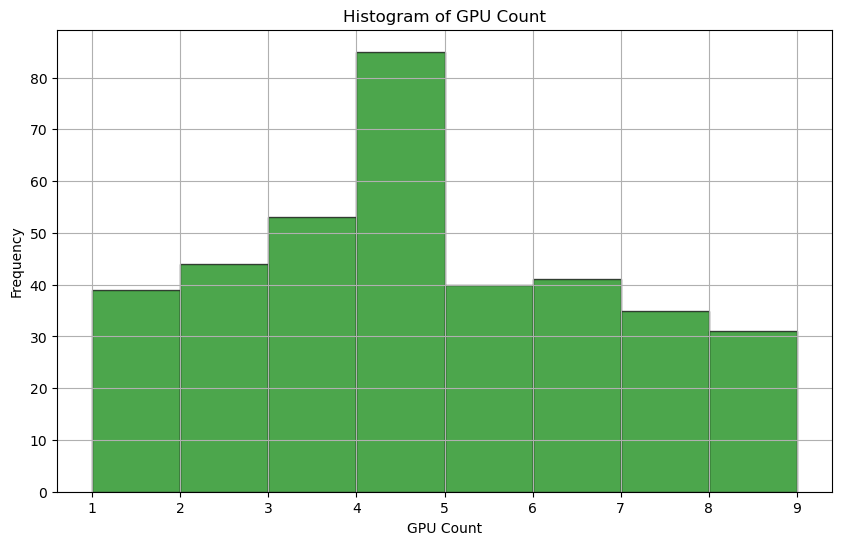

In [6]:
show(latest_data, 'Required Accelerator Count')

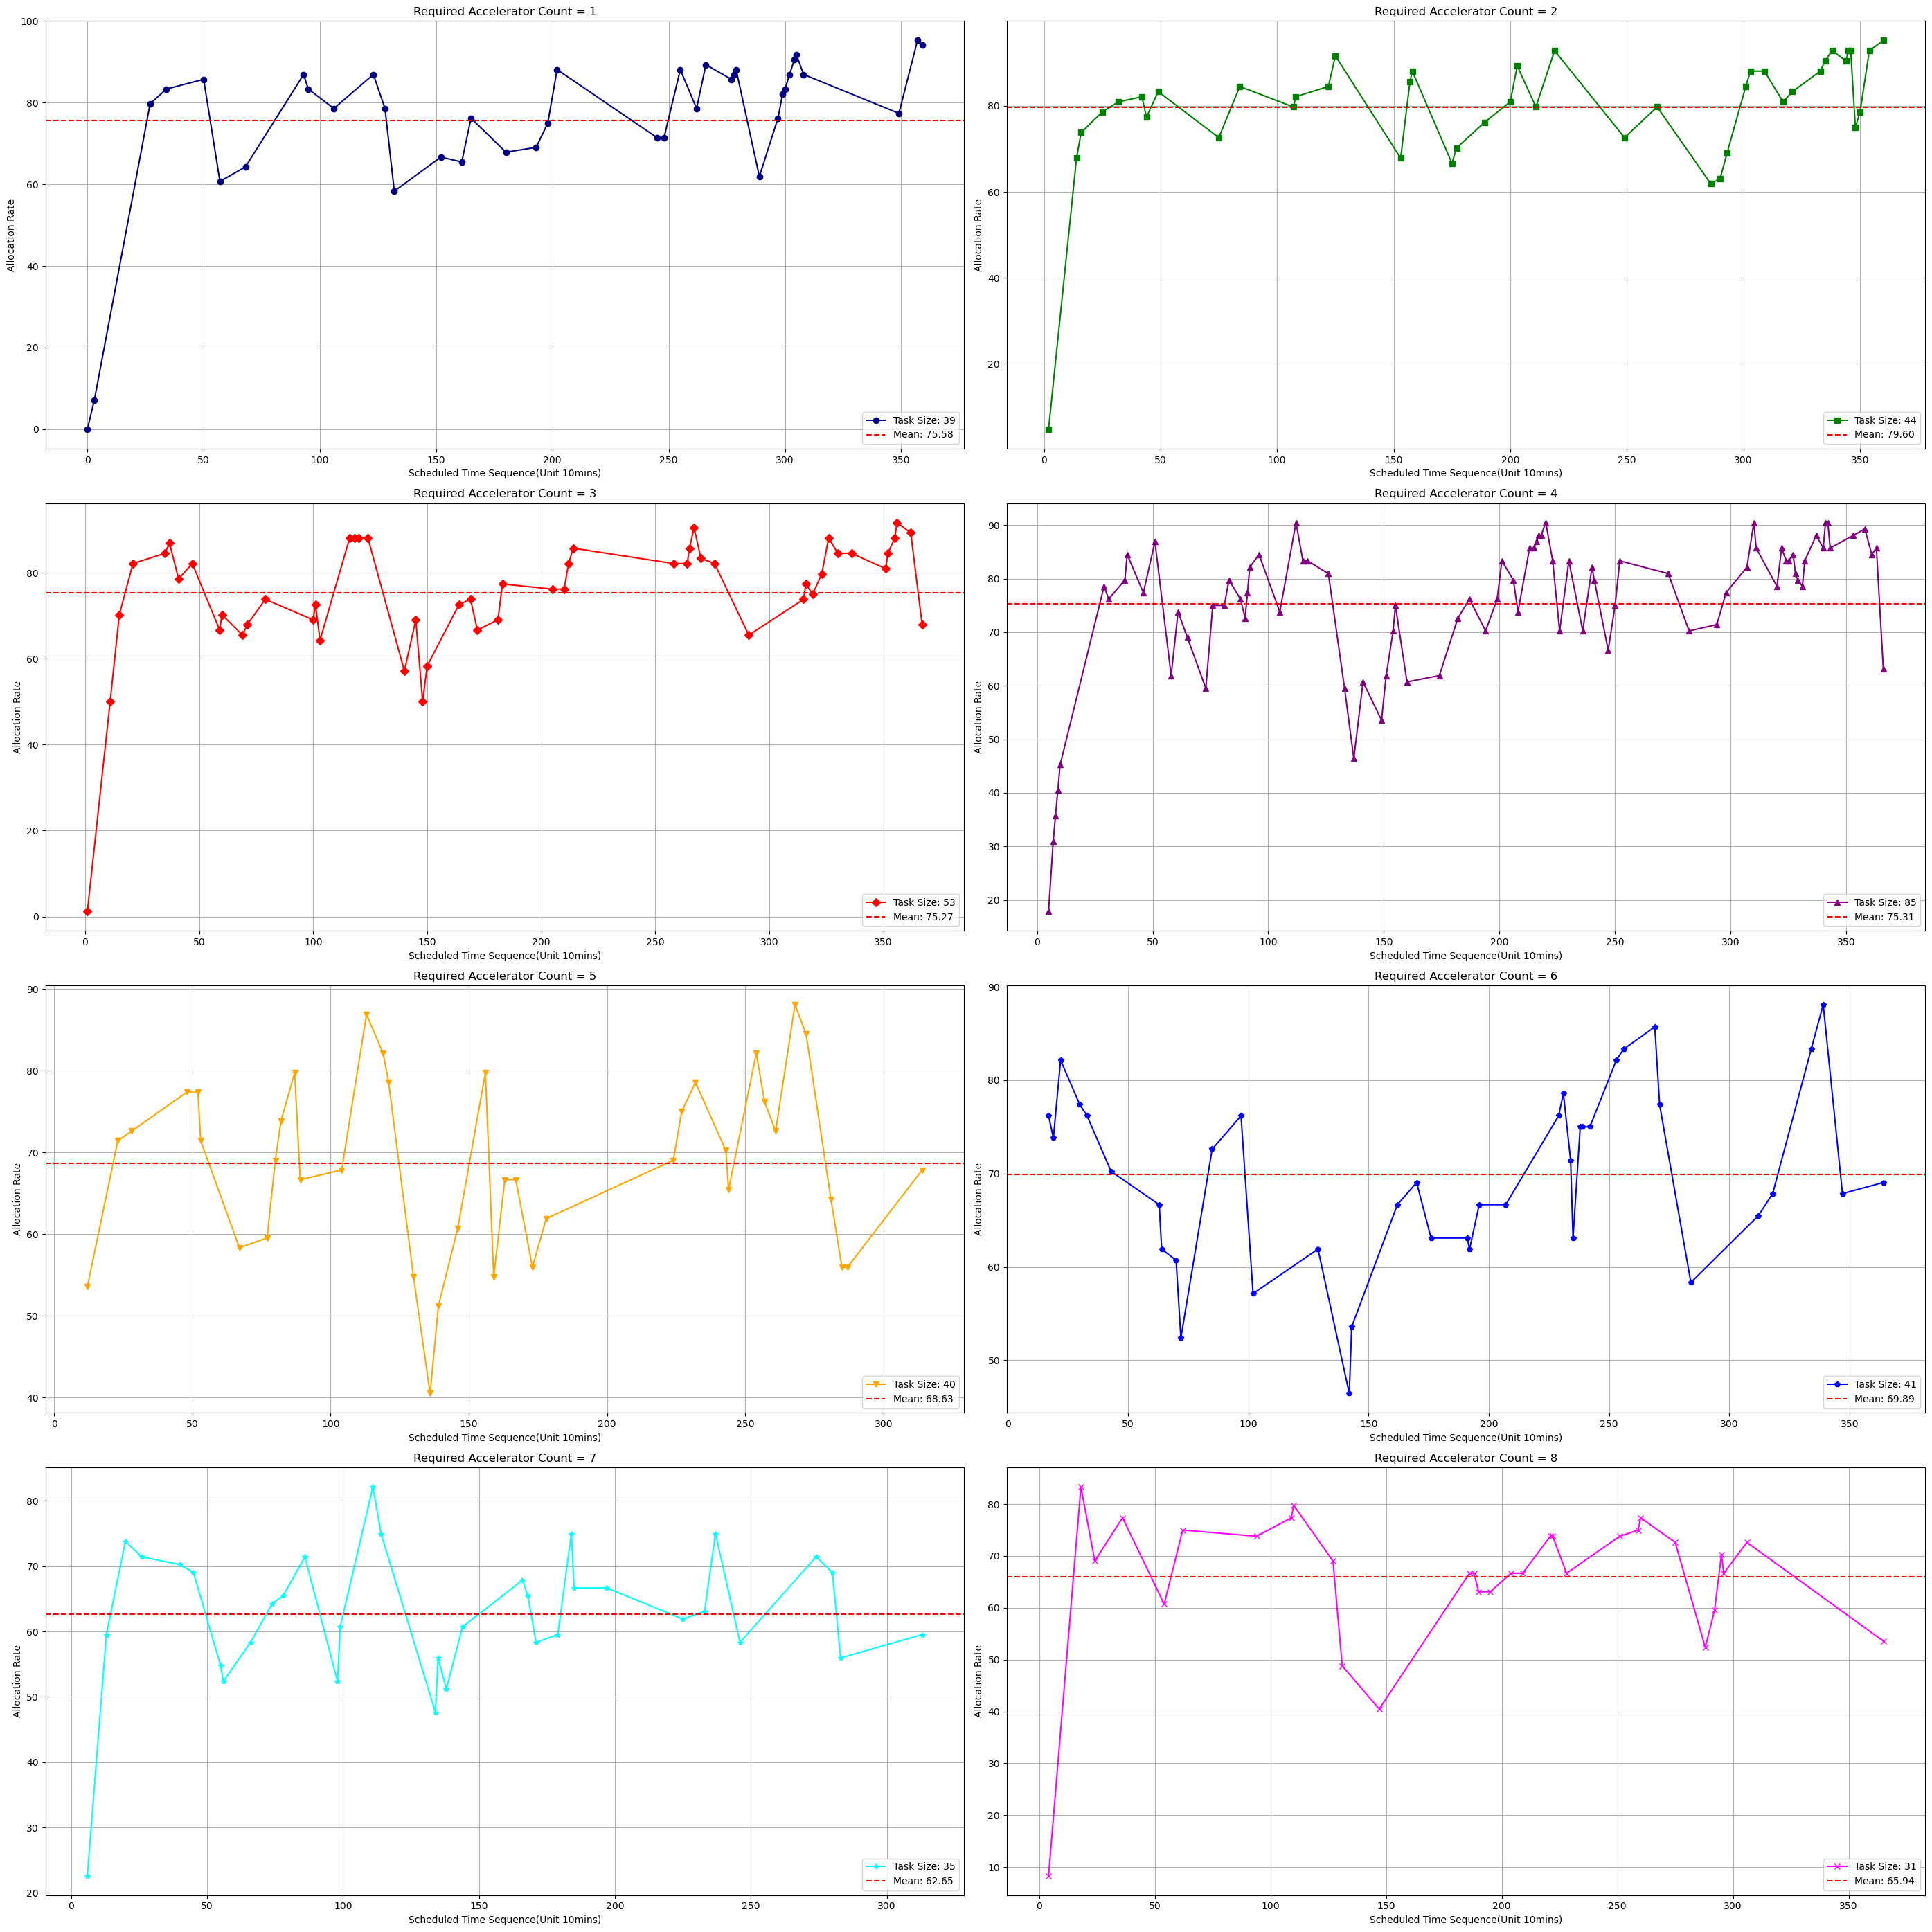

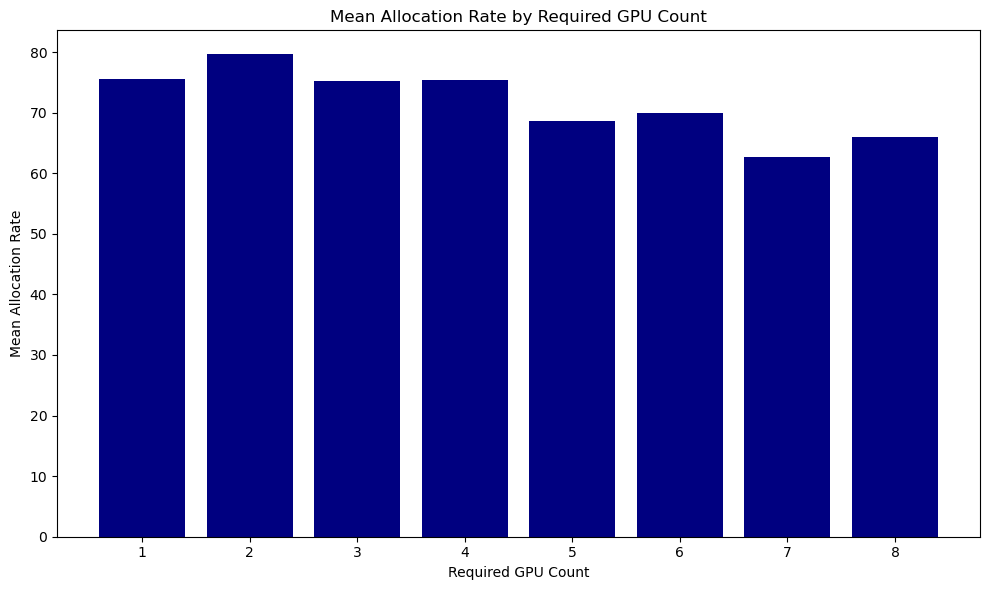

In [9]:

def plot_allocation_rate_by_accelerator_count(latest_data, required_range):
    # 8개의 그래프에 사용할 표식과 색상 리스트 생성
    markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'x']  # 서로 다른 마커
    colors = ['navy', 'green', 'red', 'purple', 'orange', 'blue', 'cyan', 'magenta']  # 서로 다른 색상

    # 8개의 그래프를 2x4 서브플롯으로 생성
    fig, axs = plt.subplots(4, 2, figsize=(28, 28))
    axs = axs.flatten()  # 2D 배열을 1D로 평탄화

    mean_allocation_rates = []  # 각 그룹의 mean allocation rate을 저장할 리스트

    # Required Accelerator Count별로 allocation_rate를 선그래프로 그리기
    for i, required in enumerate(required_range):
        ax = axs[i]
        # 각 Required Accelerator Count 그룹의 데이터 필터링
        required_data = latest_data[latest_data['Required Accelerator Count'] == required]
        
        if len(required_data) > 0:
            group_size = len(required_data)
            # 선그래프 그리기 (서로 다른 마커와 색상 적용)
            ax.plot(required_data.index, required_data['allocation_rate'], 
                    label=f'Task Size: {group_size}', 
                    marker=markers[i], color=colors[i], linestyle='-', markersize=6)

            # 평균값 계산
            mean_allocation_rate = required_data['allocation_rate'].mean()
            mean_allocation_rates.append(mean_allocation_rate)  # 각 그룹의 평균값 저장

            # 평균값 기준선 추가 (빨간색) 및 Legend에 평균값과 그룹 크기 표시
            ax.axhline(mean_allocation_rate, color='red', linestyle='--', 
                       label=f'Mean: {mean_allocation_rate:.2f}', zorder=2)

            # 그래프 설정
            ax.set_title(f'Required Accelerator Count = {required}')
            ax.set_xlabel('Scheduled Time Sequence(Unit 10mins)')
            ax.set_ylabel('Allocation Rate')

            # Legend를 우측 아래에 통일
            ax.legend(loc='lower right')
            ax.grid(True)
    
    # 그래프 출력
    plt.tight_layout()
    plt.savefig(file_name + ".png")
    plt.show()

    # 새로운 Figure로 바 그래프 생성 (전체 mean 값을 보여줄 그래프)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar([str(required) for required in required_range], mean_allocation_rates, color='navy')

    # 바 그래프 설정
    ax.set_title('Mean Allocation Rate by Required GPU Count')
    ax.set_xlabel('Required GPU Count')
    ax.set_ylabel('Mean Allocation Rate')
    
    # 그래프 출력
    plt.tight_layout()
    plt.savefig(file_name + "02.png")
    plt.show()

plot_allocation_rate_by_accelerator_count(latest_data, range(1, 9))